##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  

In [6]:
def Curve(x,a,b,c):
    return (a*x**2+b*x+c)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    RMSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if params['Prelim_N']==True:
        params['N']=int(y.shape[0]*.8/30)
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            RMSE.append(metrics.mean_squared_error(Yval,y_val)**.5)
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            RMSE.append(metrics.mean_squared_error(y_val,Yval)**.5)
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(RMSE,R2,RST.Master['TempFill'])

def RunLoop(Runs,model):
    style = {'description_width': 'initial'}
    f = FloatProgress(min=0, max=Runs['N'].count(),description='Finding Best N:',style=style) # instantiate the bar
    display(f) # display the bar
    i = 0
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(model,params,pool)
        RMSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'RMSE']=RMSE
        Runs.loc[Runs['N']==N,'R2']=R2
        f.value+=params['K']
        rmse = Runs.loc[Runs['RMSE']!=0].groupby('N').mean()#.values[0]
        rmse['se'] = Runs.loc[Runs['RMSE']!=0,['N','RMSE']].groupby('N').sem()#.values[0]
        Val = rmse['RMSE'].min()+rmse.loc[rmse['RMSE']==rmse['RMSE'].min(),'se'].values[0]
        if i > 1:
            if np.asanyarray(RMSE).mean()>Val:
                Runs = Runs.loc[Runs['RMSE']!=0]
                print('Leaving at ',N)
                break
        i+=1                
    return(Runs)

def N_Nodes(Runs,params,model,plot=False):
    params['Prelim_N']=False
    Runs = RunLoop(Runs,model)
    Group = Runs.groupby('N').mean()
    Group['Count'] = Runs[['N','RMSE']].groupby('N').count()
    Group['SD'] = Runs[['N','RMSE']].groupby('N').std()
    Group['SE'] = Runs[['N','RMSE']].groupby('N').sem()
    Group = Group.reset_index()
    Min = Group.loc[Group['RMSE']==Group['RMSE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['RMSE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['RMSE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
        print('Fitting failed to produce meaningful results')
        params['N'] = Group.loc[Group['RMSE']<+Min['RMSE'].values[0]+Min['SE'].values[0],'N'].values[0]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['RMSE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
    return(params,Runs,Group)

def Combos(Model,L,factor=None,BaseFactors=[]):
    Models=[]#BaseFactors#list()
    for c in combinations(Model,L):
        c = list(c)+BaseFactors
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def FactorTest(params,FullModel,Runs,BaseFactors = []):
    prog1 = FloatProgress(min=len(BaseFactors), max=len(FullModel+BaseFactors)-1,description='FactorTesting:') # instantiate the bar
    display(prog1) # display the bar
    Scores = pd.DataFrame()
    ModelRuns = pd.DataFrame()
    Start = 1
    for level in range(Start,len(FullModel+BaseFactors)+1):
        if level == 1:
            Models = Combos(FullModel,level)
#         elif BaseFactors != [] and i-Start == 0:
#             Models = Combos(FullModel,level-Start+1,BaseFactors=BaseFactors)
#         elif BaseFactors != [] and i-Start > 0:
#             Models = Combos(FullModel,level-Start+1,factor = Best,BaseFactors=BaseFactors)
        else:
            Models = Combos(FullModel,level,factor = Best,BaseFactors=BaseFactors)
        print('Number of Models: ',len(Models))
        prog2 = FloatProgress(min=0, max=len(Models),description='Level: '+str(level)) # instantiate the bar
        display(prog2) # display the bar
        Values = []
        for j,model in enumerate(Models):
            key = str(level)+'_'+str(j)
            Name = '+'.join(model)
            Results = RunReps(model,params,pool)
            RMSE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'RMSE':RMSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)## Might cause problems in older versions
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
            prog2.value+=1
        Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','RMSE': 'mean','R2': 'mean'}) 
        Group['SE'] = Scores[['Key','RMSE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
#         print(Min)
        Mod2Beat = Min.loc[Min['RMSE'] == Min['RMSE'].min()]
        print('Best Model @ Level ',level)
        print(Mod2Beat)
        if level>Start:
            print('Should we exit??', (Mod2Beat['RMSE']+Mod2Beat['SE']).values[0],LastMin)
            if (Mod2Beat['RMSE']+Mod2Beat['SE']).values[0]>LastMin:
                print('Exit Early')
                Scores = Scores.loc[Scores['Level']<level]
                break
        LastMin = Min['RMSE'].min()
        Best = Mod2Beat['Model'].values
        prog1.value+=1
    Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','RMSE': 'mean','R2': 'mean'})
    Group['SE'] = Scores[['Key','RMSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    return(Best,Scores,ModelRuns)

def Best_Fill(Best,Runs,Scores,params):
    N = Runs['N']
    NRuns = Runs*0
    NRuns['N']=N
    model = Best[0].split('+')

    params,Runs,Group = N_Nodes(NRuns,params,model,plot=True)
    level = 0
    key = '0_'+str(params['N'])
    Name = '+'.join(Best)
    Results = RunReps(model,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    d = {'Model':'+'.join(model),'RMSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
    score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
    Scores = Scores.append(score,ignore_index=True)
    ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
    print(params['N'])
    return(Scores,ModelRuns)

# The "Optimum" Sized Model

Illisarvik fco2


A Jupyter Widget

Models:  [['H'], ['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Grass'], ['Sparse'], ['Out_of_Basin']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
         RMSE  Level        R2     Model        SE
Key                                               
1_3  0.163566      1  0.863356  PPFD_Avg  0.003037
Models:  [['H', 'PPFD_Avg'], ['wind_speed', 'PPFD_Avg'], ['air_pressure', 'PPFD_Avg'], ['PPFD_Avg', 'AirTC_Avg'], ['PPFD_Avg', 'VPD'], ['PPFD_Avg', 'Temp'], ['PPFD_Avg', 'VWC'], ['PPFD_Avg', 'Sedge'], ['PPFD_Avg', 'Shrub'], ['PPFD_Avg', 'Grass'], ['PPFD_Avg', 'Sparse'], ['PPFD_Avg', 'Out_of_Basin']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
         RMSE  Level        R2                  Model       SE
Key                                                           
2_2  0.159379      2  0.870095  air_pressure+PPFD_Avg  0.00306
Should we exit?? 0.162439081847 0.163565984163
Models:  [['H', 'air_pressure', 'PPFD_Avg'], ['wind_speed', 'air_pressure', 'PPFD_Avg'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg'], ['air_pressure', 'PPFD_Avg', 'VPD'], ['air_pressure', 'PPFD_Avg', 'Temp'], ['air_pressure', 'PPFD_Avg', 'VWC'], ['air_pressure', 'PPFD_Avg', 'Sedge'], ['air_pressure', 'PPFD_Avg', 'Shrub'], ['air_pressure', 'PPFD_Avg', 'Grass'], ['air_pressure', 'PPFD_Avg', 'Sparse'], ['air_pressure', 'PPFD_Avg', 'Out_of_Basin']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
         RMSE  Level        R2                            Model        SE
Key                                                                      
3_2  0.155795      3  0.881637  air_pressure+PPFD_Avg+AirTC_Avg  0.002209
Should we exit?? 0.158003896667 0.159378696152
Models:  [['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Temp'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sedge'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Shrub'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Grass'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sparse'], ['air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Out_of_Basin']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
         RMSE  Level       R2                              Model        SE
Key                                                                       
4_0  0.150673      4  0.88884  H+air_pressure+PPFD_Avg+AirTC_Avg  0.002552
Should we exit?? 0.153225224895 0.155795215665
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Temp'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sedge'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Shrub'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Grass'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sparse'], ['H', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Out_of_Basin']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
         RMSE  Level        R2                                         Model  \
Key                                                                            
5_0  0.145109      5  0.900383  H+wind_speed+air_pressure+PPFD_Avg+AirTC_Avg   

           SE  
Key            
5_0  0.001756  
Should we exit?? 0.146865124133 0.150672909166
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Temp'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sedge'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Shrub'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Grass'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Out_of_Basin']]
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
         RMSE  Level        R2  \
Key                              
6_2  0.137819      6  0.911112   

                                                Model        SE  
Key                                                              
6_2  H+wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+VWC  0.001305  
Should we exit?? 0.13912351597 0.145109220317
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'VWC'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'Temp', 'VWC'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sedge'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Shrub'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Grass'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Out_of_Basin']]
Number of Models:  7


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
         RMSE  Level        R2  \
Key                              
7_0  0.135854      7  0.911804   

                                                 Model        SE  
Key                                                               
7_0  H+wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+V...  0.002645  
Should we exit?? 0.13849827051 0.137818701707
Exit Early
['H+wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+VWC']       Key  Level                                              Model        R2  \
0     1_0      1                                                  H  0.591627   
1     1_0      1                                                  H  0.603455   
2     1_0      1                                                  H  0.590044   
3     1_0      1                                                  H  0.611620   
4     1_0      1                                                  H  0.579610   
5     1_0      1                                                  H  0.619401 

A Jupyter Widget

Leaving at  74


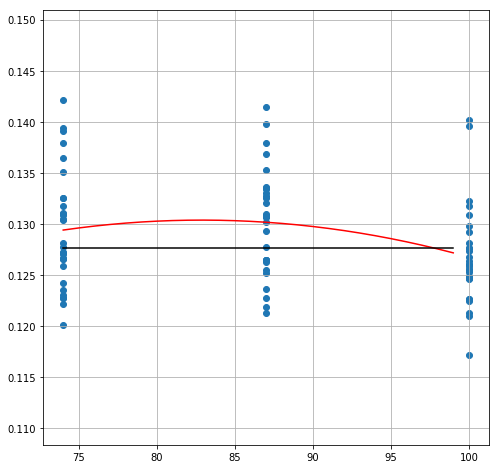

98
Illisarvik fch4


A Jupyter Widget

Models:  [['H'], ['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Grass'], ['Sparse'], ['Out_of_Basin']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
         RMSE  Level        R2  Model        SE
Key                                            
1_8  0.625577      1 -6.684796  Sedge  0.007118
Models:  [['H', 'Sedge'], ['wind_speed', 'Sedge'], ['air_pressure', 'Sedge'], ['PPFD_Avg', 'Sedge'], ['AirTC_Avg', 'Sedge'], ['VPD', 'Sedge'], ['Temp', 'Sedge'], ['VWC', 'Sedge'], ['Sedge', 'Shrub'], ['Sedge', 'Grass'], ['Sedge', 'Sparse'], ['Sedge', 'Out_of_Basin']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
        RMSE  Level        R2      Model        SE
Key                                               
2_7  0.46008      2 -0.187289  VWC+Sedge  0.005571
Should we exit?? 0.465651222071 0.625576824745
Models:  [['H', 'VWC', 'Sedge'], ['wind_speed', 'VWC', 'Sedge'], ['air_pressure', 'VWC', 'Sedge'], ['PPFD_Avg', 'VWC', 'Sedge'], ['AirTC_Avg', 'VWC', 'Sedge'], ['VPD', 'VWC', 'Sedge'], ['Temp', 'VWC', 'Sedge'], ['VWC', 'Sedge', 'Shrub'], ['VWC', 'Sedge', 'Grass'], ['VWC', 'Sedge', 'Sparse'], ['VWC', 'Sedge', 'Out_of_Basin']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
         RMSE  Level        R2        Model        SE
Key                                                  
3_0  0.410092      3  0.250749  H+VWC+Sedge  0.007266
Should we exit?? 0.41735764601 0.460080209986
Models:  [['H', 'wind_speed', 'VWC', 'Sedge'], ['H', 'air_pressure', 'VWC', 'Sedge'], ['H', 'PPFD_Avg', 'VWC', 'Sedge'], ['H', 'AirTC_Avg', 'VWC', 'Sedge'], ['H', 'VPD', 'VWC', 'Sedge'], ['H', 'Temp', 'VWC', 'Sedge'], ['H', 'VWC', 'Sedge', 'Shrub'], ['H', 'VWC', 'Sedge', 'Grass'], ['H', 'VWC', 'Sedge', 'Sparse'], ['H', 'VWC', 'Sedge', 'Out_of_Basin']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
         RMSE  Level        R2                  Model        SE
Key                                                            
4_3  0.381554      4  0.409871  H+AirTC_Avg+VWC+Sedge  0.005666
Should we exit?? 0.38721948361 0.410091530256
Models:  [['H', 'wind_speed', 'AirTC_Avg', 'VWC', 'Sedge'], ['H', 'air_pressure', 'AirTC_Avg', 'VWC', 'Sedge'], ['H', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sedge'], ['H', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge'], ['H', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Grass'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Sparse'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Out_of_Basin']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
         RMSE  Level        R2                        Model        SE
Key                                                                  
5_5  0.365086      5  0.482947  H+AirTC_Avg+VWC+Sedge+Shrub  0.006432
Should we exit?? 0.371517824668 0.381553831537
Models:  [['H', 'wind_speed', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub'], ['H', 'air_pressure', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub'], ['H', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub'], ['H', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge', 'Shrub'], ['H', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Shrub'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Grass'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Sparse'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin']]
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
         RMSE  Level        R2                                     Model  \
Key                                                                        
6_7  0.355071      6  0.523912  H+AirTC_Avg+VWC+Sedge+Shrub+Out_of_Basin   

           SE  
Key            
6_7  0.006291  
Should we exit?? 0.361362386346 0.365085612157
Models:  [['H', 'wind_speed', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'air_pressure', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Out_of_Basin'], ['H', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Sparse', 'Out_of_Basin']]
Number of Models:  7


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
         RMSE  Level        R2  \
Key                              
7_0  0.346105      7  0.548055   

                                                 Model        SE  
Key                                                               
7_0  H+wind_speed+AirTC_Avg+VWC+Sedge+Shrub+Out_of_...  0.004576  
Should we exit?? 0.350681083908 0.35507112676
Models:  [['H', 'wind_speed', 'air_pressure', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'wind_speed', 'PPFD_Avg', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'wind_speed', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'wind_speed', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin'], ['H', 'wind_speed', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Out_of_Basin'], ['H', 'wind_speed', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub', 'Sparse', 'Out_of_Basin']]
Number of Models:  6


A Jupyter Widget

Using TensorFlow backend.


Best Model @ Level  8
         RMSE  Level        R2  \
Key                              
8_5  0.341866      8  0.561339   

                                                 Model        SE  
Key                                                               
8_5  H+wind_speed+AirTC_Avg+VWC+Sedge+Shrub+Sparse+...  0.004348  
Should we exit?? 0.34621401949 0.346105056446
Exit Early
['H+wind_speed+AirTC_Avg+VWC+Sedge+Shrub+Out_of_Basin']       Key  Level                                            Model          R2  \
0     1_0      1                                                H -103.769870   
1     1_0      1                                                H -154.789473   
2     1_0      1                                                H  -71.790743   
3     1_0      1                                                H  -87.459326   
4     1_0      1                                                H  -84.808415   
5     1_0      1                                                H -108.7589

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Leaving at  74


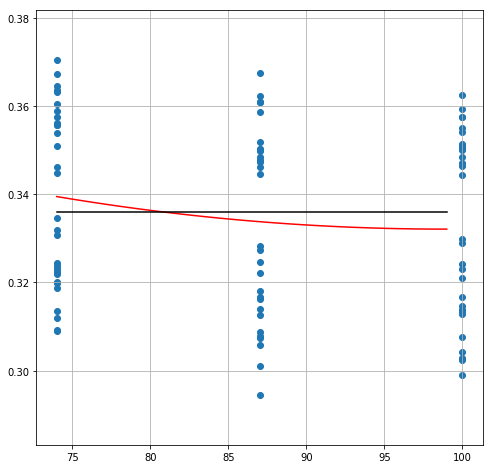

81
FishIsland fco2


A Jupyter Widget

Models:  [['H'], ['Wind Spd'], ['air pressure'], ['Ta'], ['Rn'], ['PPFD'], ['Rain'], ['Water Table'], ['Ts 2.5 cm'], ['Ts 15 cm'], ['VWC'], ['Active Layer'], ['24H Rain'], ['Wtr Tbl Trnd']]
Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
         RMSE  Level        R2 Model        SE
Key                                           
1_5  0.081787      1  0.571307  PPFD  0.000793
Models:  [['H', 'PPFD'], ['Wind Spd', 'PPFD'], ['air pressure', 'PPFD'], ['Ta', 'PPFD'], ['Rn', 'PPFD'], ['PPFD', 'Rain'], ['PPFD', 'Water Table'], ['PPFD', 'Ts 2.5 cm'], ['PPFD', 'Ts 15 cm'], ['PPFD', 'VWC'], ['PPFD', 'Active Layer'], ['PPFD', '24H Rain'], ['PPFD', 'Wtr Tbl Trnd']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
        RMSE  Level        R2     Model        SE
Key                                              
2_9  0.07783      2  0.613745  PPFD+VWC  0.000773
Should we exit?? 0.0786032595545 0.0817874224669
Models:  [['H', 'PPFD', 'VWC'], ['Wind Spd', 'PPFD', 'VWC'], ['air pressure', 'PPFD', 'VWC'], ['Ta', 'PPFD', 'VWC'], ['Rn', 'PPFD', 'VWC'], ['PPFD', 'Rain', 'VWC'], ['PPFD', 'Water Table', 'VWC'], ['PPFD', 'Ts 2.5 cm', 'VWC'], ['PPFD', 'Ts 15 cm', 'VWC'], ['PPFD', 'VWC', 'Active Layer'], ['PPFD', 'VWC', '24H Rain'], ['PPFD', 'VWC', 'Wtr Tbl Trnd']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
        RMSE  Level        R2        Model        SE
Key                                                 
3_3  0.07349      3  0.670059  Ta+PPFD+VWC  0.000616
Should we exit?? 0.0741062657183 0.0778301425642
Models:  [['H', 'Ta', 'PPFD', 'VWC'], ['Wind Spd', 'Ta', 'PPFD', 'VWC'], ['air pressure', 'Ta', 'PPFD', 'VWC'], ['Ta', 'Rn', 'PPFD', 'VWC'], ['Ta', 'PPFD', 'Rain', 'VWC'], ['Ta', 'PPFD', 'Water Table', 'VWC'], ['Ta', 'PPFD', 'Ts 2.5 cm', 'VWC'], ['Ta', 'PPFD', 'Ts 15 cm', 'VWC'], ['Ta', 'PPFD', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'VWC', '24H Rain'], ['Ta', 'PPFD', 'VWC', 'Wtr Tbl Trnd']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
         RMSE  Level        R2                     Model        SE
Key                                                               
4_8  0.070598      4  0.704385  Ta+PPFD+VWC+Active Layer  0.000519
Should we exit?? 0.0711168819569 0.0734902109097
Models:  [['H', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['air pressure', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['Ta', 'Rn', 'PPFD', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'Rain', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'Water Table', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer'], ['Ta', 'PPFD', 'VWC', 'Active Layer', '24H Rain'], ['Ta', 'PPFD', 'VWC', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
         RMSE  Level       R2                       Model        SE
Key                                                                
5_0  0.067596      5  0.73404  H+Ta+PPFD+VWC+Active Layer  0.000452
Should we exit?? 0.0680476084295 0.0705978206643
Models:  [['H', 'Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['H', 'air pressure', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['H', 'Ta', 'Rn', 'PPFD', 'VWC', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Rain', 'VWC', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer'], ['H', 'Ta', 'PPFD', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Ta', 'PPFD', 'VWC', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
         RMSE  Level        R2                                Model        SE
Key                                                                          
6_0  0.063864      6  0.768424  H+Wind Spd+Ta+PPFD+VWC+Active Layer  0.000749
Should we exit?? 0.0646126250634 0.067595648935
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rn', 'PPFD', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Rain', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
         RMSE  Level       R2  \
Key                             
7_3  0.063264      7  0.77524   

                                               Model        SE  
Key                                                             
7_3  H+Wind Spd+Ta+PPFD+Water Table+VWC+Active Layer  0.000643  
Should we exit?? 0.0639076638342 0.0638636232283
Exit Early
['H+Wind Spd+Ta+PPFD+VWC+Active Layer']       Key  Level                                    Model        R2      RMSE
0     1_0      1                                        H  0.433179  0.092854
1     1_0      1                                        H  0.482100  0.086947
2     1_0      1                                        H  0.424137  0.091811
3     1_0      1                                        H  0.505149  0.086802
4     1_0      1                                        H  0.409785  0.091812
5     1_0      1                                        H  0.469177  0.086742
6     1_0      1                     

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Leaving at  48


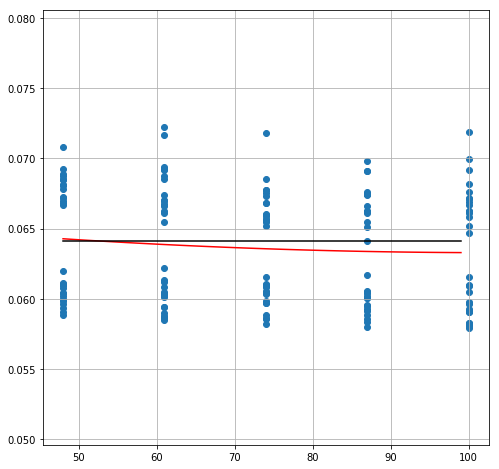

53
FishIsland fch4


A Jupyter Widget

Models:  [['H'], ['Wind Spd'], ['air pressure'], ['Ta'], ['Rn'], ['PPFD'], ['Rain'], ['Water Table'], ['Ts 2.5 cm'], ['Ts 15 cm'], ['VWC'], ['Active Layer'], ['24H Rain'], ['Wtr Tbl Trnd']]
Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
         RMSE  Level        R2 Model        SE
Key                                           
1_0  0.835651      1 -1.378954     H  0.007096
Models:  [['H', 'Wind Spd'], ['H', 'air pressure'], ['H', 'Ta'], ['H', 'Rn'], ['H', 'PPFD'], ['H', 'Rain'], ['H', 'Water Table'], ['H', 'Ts 2.5 cm'], ['H', 'Ts 15 cm'], ['H', 'VWC'], ['H', 'Active Layer'], ['H', '24H Rain'], ['H', 'Wtr Tbl Trnd']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
         RMSE  Level        R2       Model        SE
Key                                                 
2_0  0.791437      2 -0.858552  H+Wind Spd  0.001795
Should we exit?? 0.793231269338 0.835651025368
Models:  [['H', 'Wind Spd', 'air pressure'], ['H', 'Wind Spd', 'Ta'], ['H', 'Wind Spd', 'Rn'], ['H', 'Wind Spd', 'PPFD'], ['H', 'Wind Spd', 'Rain'], ['H', 'Wind Spd', 'Water Table'], ['H', 'Wind Spd', 'Ts 2.5 cm'], ['H', 'Wind Spd', 'Ts 15 cm'], ['H', 'Wind Spd', 'VWC'], ['H', 'Wind Spd', 'Active Layer'], ['H', 'Wind Spd', '24H Rain'], ['H', 'Wind Spd', 'Wtr Tbl Trnd']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
         RMSE  Level        R2                    Model       SE
Key                                                             
3_9  0.757944      3 -0.466594  H+Wind Spd+Active Layer  0.00242
Should we exit?? 0.760363470854 0.791436654085
Models:  [['H', 'Wind Spd', 'air pressure', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Active Layer'], ['H', 'Wind Spd', 'Rn', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Active Layer'], ['H', 'Wind Spd', 'Rain', 'Active Layer'], ['H', 'Wind Spd', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
         RMSE  Level        R2                       Model        SE
Key                                                                 
4_1  0.729495      4 -0.299233  H+Wind Spd+Ta+Active Layer  0.001628
Should we exit?? 0.731122406424 0.757943533532
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rn', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rain', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
         RMSE  Level        R2                                   Model  \
Key                                                                      
5_4  0.703616      5 -0.171632  H+Wind Spd+Ta+Water Table+Active Layer   

           SE  
Key            
5_4  0.001556  
Should we exit?? 0.705171927818 0.729494668561
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rn', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rain', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
         RMSE  Level        R2  \
Key                              
6_4  0.699286      6 -0.135717   

                                                Model        SE  
Key                                                              
6_4  H+Wind Spd+Ta+Water Table+Ts 2.5 cm+Active Layer  0.002045  
Should we exit?? 0.701330455482 0.703616324555
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rn', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Rain', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer', 

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
         RMSE  Level        R2  \
Key                              
7_6  0.696569      7 -0.015629   

                                                 Model        SE  
Key                                                               
7_6  H+Wind Spd+Ta+Water Table+Ts 2.5 cm+Active Lay...  0.002032  
Should we exit?? 0.698600719817 0.699285900184
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Rn', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Rain', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H R

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  8
         RMSE  Level        R2  \
Key                              
8_0  0.691924      8  0.041148   

                                                 Model        SE  
Key                                                               
8_0  H+Wind Spd+air pressure+Ta+Water Table+Ts 2.5 ...  0.002506  
Should we exit?? 0.694430669749 0.696568933234
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Rn', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Rain', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Ra

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  9
         RMSE  Level        R2  \
Key                              
9_4  0.689448      9  0.045109   

                                                 Model        SE  
Key                                                               
9_4  H+Wind Spd+air pressure+Ta+Water Table+Ts 2.5 ...  0.004336  
Should we exit?? 0.693784588529 0.691924289643
Exit Early
['H+Wind Spd+air pressure+Ta+Water Table+Ts 2.5 cm+Active Layer+24H Rain']       Key  Level                                              Model        R2  \
0     1_0      1                                                  H -1.552960   
1     1_0      1                                                  H -1.399479   
2     1_0      1                                                  H -1.567994   
3     1_0      1                                                  H -1.301652   
4     1_0      1                                                  H -1.445392   
5     1_0      1                                       

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Leaving at  61


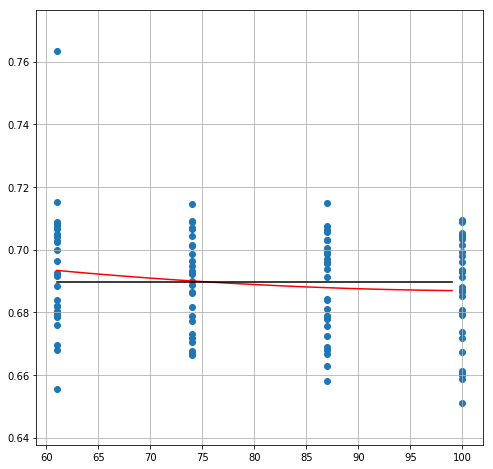

76


In [8]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Full'
cwd = os.getcwd()
def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        BaseFactors = ['Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed','VWC','VPD']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model,BaseFactors)

def Params(Func,Y,MP = True):
    params = {}
    params['proc']=3
    if MP == False:
        params['proc']=1
    if Func == 'Full':
        epochs = 200
        K = 30
        splits_per_mod = 2
        N = np.linspace(100,10,8,dtype='int32')
    elif Func == 'Test':
        epochs = 200
        K = 30
        splits_per_mod = 2
        N = np.linspace(70,10,5,dtype='int32')
    N = np.repeat(N,K)
    d = {'N':N.astype(int)}
    Runs = pd.DataFrame(data=d)
    Runs['RMSE'] = 0.0
    Runs['R2'] = 0.0
    Runs['Model']=0
    params['K'] = K
    params['epochs'] = epochs
    params['Y'] = Y
    params['splits_per_mod'] = splits_per_mod
    params['Save'] = {}
    params['Save']['Weights']=False
    params['Save']['Model']=False
    
    return(Runs,params)


MP=True
if Scope == 'Full':
    MP = True
if __name__=='__main__'and MP==True:
    pool = Pool(processes=3,maxtasksperchild=75)
else:pool=None
    
for Site in ['Illisarvik','FishIsland']:
# Site='Illisarvik'
# FillVar = 'fco2'
    for FillVar in ['fco2','fch4']:
        print(Site,FillVar)
        FullModel,BaseFactors = ModSelect(Scope,Site)
        Runs,params = Params(Scope,FillVar,MP)
        params['Dpath'] = cwd+'/'+Site+'/'
        params['Prelim_N']=True
        Best,Scores,ModelRuns = FactorTest(params,FullModel,Runs,BaseFactors)
        print(Best,Scores)
        Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
        Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
        ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

if __name__=='__main__'and MP==True:
    pool.close()

In [4]:
print('kitty')

kitty
